
# Analyze the results of training on masked CTX images

Here we do some preliminary analysis on the trained model results. This analyzes 48 model trainings and applications from the Saha algorithm.

In [1]:
import pandas as pd
import os
import numpy as np
from scipy.optimize import linear_sum_assignment
import rioxarray as rxr
from PIL import Image
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import mode
import geopandas as gpd

### Useful functions for displaying images in the right colors

In [2]:
### COLORS
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter/background (red)
           6 : (255, 0, 255),   # (pink)
           7 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        #print(c)
        #print(i)
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d


## Algorithm to do feature correspondence and calculate the overlap

In [3]:
def simple_overlap(pred,gt,plotting=False):
    
    LF0 = pred[gt == 0]
    LF1 = pred[gt == 1]
    LF2 = pred[gt == 2]
    LF3 = pred[gt == 3]
    LF4 = pred[gt == 4]

    cluster_num = len(np.unique(pred))
    totals = np.zeros((cluster_num,5))
    feature_map = np.zeros(cluster_num)
    # print(cluster_num)
    mapped = pred.copy()
    mapped_static = pred.copy()
    for i in range(cluster_num):
        totals[i,0] = np.sum(LF0 == i)
        totals[i,1] = np.sum(LF1 == i)
        totals[i,2] = np.sum(LF2 == i)
        totals[i,3] = np.sum(LF3 == i)
        totals[i,4] = np.sum(LF4 == i)
        feature_map[i] = [k for k, x in enumerate(totals[i,:] == np.max(totals[i,:])) if x][0]
        # print("Loop: ", i, "Feature Map: ", feature_map[i])
        mapped[mapped_static == i] = feature_map[i]

    valid_mask = ~np.isnan(pred)
    pred_nonan_flat = pred[valid_mask].ravel()
    gt_nonan_flat = gt[valid_mask].ravel()

    f1 = f1_score(gt_nonan_flat, pred_nonan_flat, average='weighted', zero_division=0)
    print(f'F1 Score: {f1:.4f}')

    if plotting:
        # Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        plot_vmin = 0
        plot_vmax_pred = np.nanmax(np.unique(pred))
        plot_vmax_gt = np.nanmax(np.unique(gt))

        # Plot the clustered image
        axes[0].imshow(pred, cmap='jet', vmin=plot_vmin, vmax=plot_vmax_pred)
        axes[0].set_title('Clustered Image')
        axes[0].axis('off')

        # Plot the ground truth image
        axes[1].imshow(gt, cmap='jet', vmin=plot_vmin, vmax=plot_vmax_gt)
        axes[1].set_title('Ground Truth Image')
        axes[1].axis('off')

        # Plot the mapped image
        axes[2].imshow(mapped, cmap='jet', vmin=plot_vmin, vmax=plot_vmax_gt)
        axes[2].set_title('Mapped Image')
        axes[2].axis('off')
    
    return mapped, feature_map, f1

## Load in the results

In [4]:
# Directory containing the files
directory = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/results/CTX_masked_only/images'

# Get list of filenames in the directory
filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Initialize lists to store data
ctxIMG = []
ctxDEM = []
ctxSLOPE = []
ff = []
ps = []
mask = []
filename_list = []

# Process each filename
for filename in filenames:
    ctxIMG.append(1 if 'ctxIMG' in filename else 0)
    ctxDEM.append(1 if 'ctxDEM' in filename else 0)
    ctxSLOPE.append(1 if 'ctxSLOPE' in filename else 0)
    mask.append(1 if 'mask' in filename else 0)
    
    ff_value = filename.split('_ff')[1].split('_')[0]
    ps_value = filename.split('_ps')[1].split('.')[0]
    
    ff.append(int(ff_value))
    ps.append(int(ps_value))
    filename_list.append(filename)

# Create DataFrame
df = pd.DataFrame({
    'filename': filename_list,
    'mask': mask,
    'ctxIMG': ctxIMG,
    'ctxDEM': ctxDEM,
    'ctxSLOPE': ctxSLOPE,
    'ff': ff,
    'ps': ps
})

# Add empty columns to the dataframe
df['LM2_f1'] = np.nan
df['LM3_f1'] = np.nan
df['LM4_f1'] = np.nan
df['LM2_f1_mask'] = np.nan
df['LM3_f1_mask'] = np.nan
df['LM4_f1_mask'] = np.nan
# df['LM2_feature_map'] = np.nan
# df['LM3_feature_map'] = np.nan
# df['LM4_feature_map'] = np.nan
# df['LM2_feature_map_mask'] = np.nan
# df['LM3_feature_map_mask'] = np.nan
# df['LM4_feature_map_mask'] = np.nan

print(df.shape)
df.head()

(48, 13)


filename  mask  ctxIMG  ctxDEM  ctxSLOPE  \
0            mask_ctxIMG_ctxDEM_ff6_ps336.png     1       1       1         0   
1          mask_ctxDEM_ctxSLOPE_ff6_ps224.png     1       0       1         1   
2  mask_ctxIMG_ctxDEM_ctxSLOPE_ff10_ps336.png     1       1       1         1   
3          mask_ctxDEM_ctxSLOPE_ff4_ps448.png     1       0       1         1   
4         mask_ctxIMG_ctxSLOPE_ff10_ps224.png     1       1       0         1   

   ff   ps  LM2_f1  LM3_f1  LM4_f1  LM2_f1_mask  LM3_f1_mask  LM4_f1_mask  
0   6  336     NaN     NaN     NaN          NaN          NaN          NaN  
1   6  224     NaN     NaN     NaN          NaN          NaN          NaN  
2  10  336     NaN     NaN     NaN          NaN          NaN          NaN  
3   4  448     NaN     NaN     NaN          NaN          NaN          NaN  
4  10  224     NaN     NaN     NaN          NaN          NaN          NaN

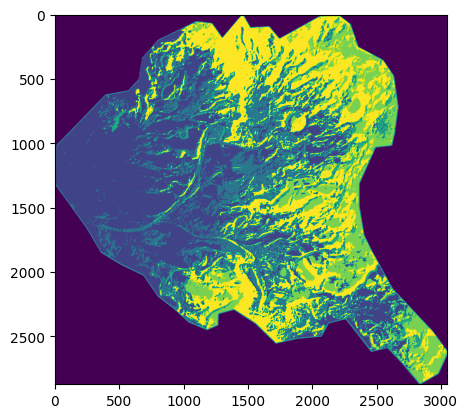

In [6]:
plt.imshow(predicted_masked)

In [7]:
data_path = "/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/ai_ready_masked/" # This is an example, change it to your own path
ctxIMG_masked = rxr.open_rasterio(data_path + "ctxIMG_aiready_masked.tif", cache=False)
masked_vals = ctxIMG_masked.values[0,:,:]

LM_file2 = Image.open("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map_2.tif")
LM_file3 = Image.open("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map_3.tif")
LM_file4 = Image.open("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map_4.tif")

LM2 = np.array(LM_file2)
LM3 = np.array(LM_file3)
LM4 = np.array(LM_file4)

LM2_masked = LM2.astype(float).copy()
LM2_masked[masked_vals == 0] = np.nan

LM3_masked = LM3.astype(float).copy()
LM3_masked[masked_vals == 0] = np.nan

LM4_masked = LM4.astype(float).copy()
LM4_masked[masked_vals == 0] = np.nan

for i in range(df.shape[0]):
    print(i)
    results_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/results/CTX_masked_only/images/'
    predicted_file = Image.open(results_path + df["filename"].loc[i])
    predicted_color = np.array(predicted_file)
    predicted = convert_from_color(predicted_color[:,:,:-1])
    predicted_masked = predicted.astype(float).copy()
    predicted_masked[masked_vals == 0] = np.nan

    # LM2
    LM2_mapped_img_mask, LM2_feature_map_mask, LM2_f1_mask = simple_overlap(predicted_masked, LM2_masked)

    # LM3
    LM3_mapped_img_mask, LM3_feature_map_mask, LM3_f1_mask = simple_overlap(predicted_masked, LM3_masked)

    # LM4
    LM4_mapped_img_mask, LM4_feature_map_mask, LM4_f1_mask = simple_overlap(predicted_masked, LM4_masked)

    df.at[i, 'LM2_f1_mask'] = LM2_f1_mask
    df.at[i, 'LM3_f1_mask'] = LM3_f1_mask
    df.at[i, 'LM4_f1_mask'] = LM4_f1_mask
    # df.at[i, 'LM2_feature_map'] = LM2_feature_map
    # df.at[i, 'LM3_feature_map'] = LM3_feature_map
    # df.at[i, 'LM4_feature_map'] = LM4_feature_map
    # df.at[i, 'LM2_feature_map_mask'] = LM2_feature_map_mask
    # df.at[i, 'LM3_feature_map_mask'] = LM3_feature_map_mask
    # df.at[i, 'LM4_feature_map_mask'] = LM4_feature_map_mask


0
F1 Score: 0.3827
F1 Score: 0.3127
F1 Score: 0.3263
1
F1 Score: 0.0079
F1 Score: 0.0115
F1 Score: 0.0175
2
F1 Score: 0.3388
F1 Score: 0.1778
F1 Score: 0.1586
3
F1 Score: 0.2974
F1 Score: 0.1001
F1 Score: 0.0963
4
F1 Score: 0.2870
F1 Score: 0.1332
F1 Score: 0.1333
5
F1 Score: 0.2976
F1 Score: 0.1438
F1 Score: 0.1552
6
F1 Score: 0.0359
F1 Score: 0.1272
F1 Score: 0.1222
7
F1 Score: 0.5167
F1 Score: 0.1543
F1 Score: 0.1590
8
F1 Score: 0.3638
F1 Score: 0.2397
F1 Score: 0.2124
9
F1 Score: 0.0460
F1 Score: 0.0916
F1 Score: 0.0606
10
F1 Score: 0.2205
F1 Score: 0.2044
F1 Score: 0.1688
11
F1 Score: 0.4316
F1 Score: 0.1510
F1 Score: 0.1787
12
F1 Score: 0.2508
F1 Score: 0.1346
F1 Score: 0.1521
13
F1 Score: 0.3018
F1 Score: 0.1849
F1 Score: 0.1804
14
F1 Score: 0.1802
F1 Score: 0.0681
F1 Score: 0.0639
15
F1 Score: 0.4489
F1 Score: 0.2521
F1 Score: 0.2417
16
F1 Score: 0.0979
F1 Score: 0.1444
F1 Score: 0.1211
17
F1 Score: 0.0576
F1 Score: 0.0872
F1 Score: 0.0804
18
F1 Score: 0.3855
F1 Score: 0.1524
F

In [8]:
# List of f1 columns
f1_columns = ['LM2_f1_mask', 'LM3_f1_mask', 'LM4_f1_mask']

# Get the entry with the highest value for each f1 column
highest_entries = df.loc[df[f1_columns].idxmax()]

highest_entries

filename  mask  ctxIMG  ctxDEM  ctxSLOPE  ff  \
7   mask_ctxIMG_ctxDEM_ff10_ps224.png     1       1       1         0  10   
22   mask_ctxIMG_ctxDEM_ff6_ps224.png     1       1       1         0   6   
22   mask_ctxIMG_ctxDEM_ff6_ps224.png     1       1       1         0   6   

     ps  LM2_f1  LM3_f1  LM4_f1  LM2_f1_mask  LM3_f1_mask  LM4_f1_mask  
7   224     NaN     NaN     NaN     0.516715     0.154319     0.158963  
22  224     NaN     NaN     NaN     0.464448     0.326971     0.355541  
22  224     NaN     NaN     NaN     0.464448     0.326971     0.355541

F1 Score: 0.4644
F1 Score: 0.3270
F1 Score: 0.3555


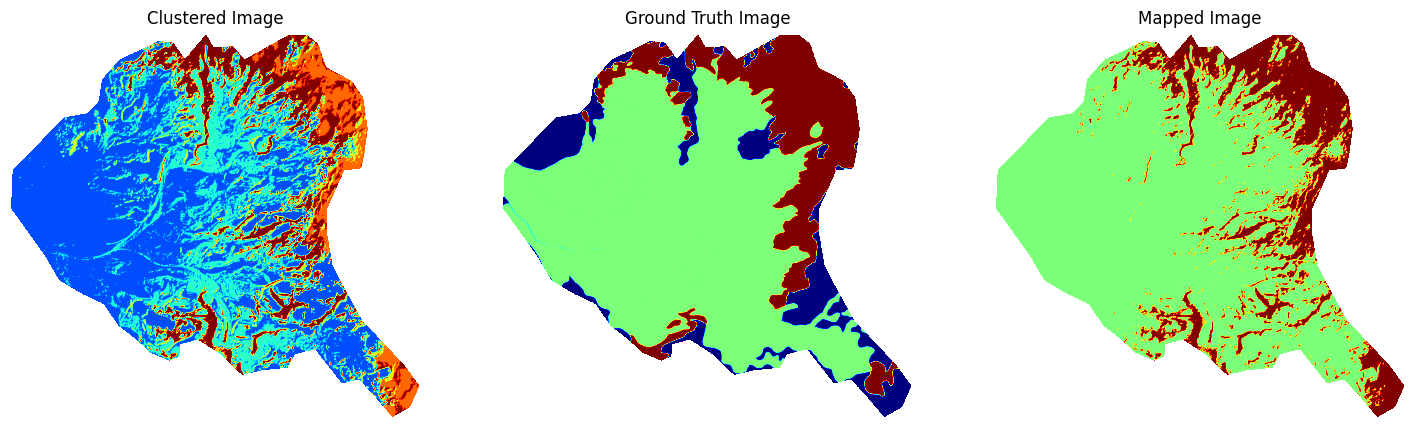

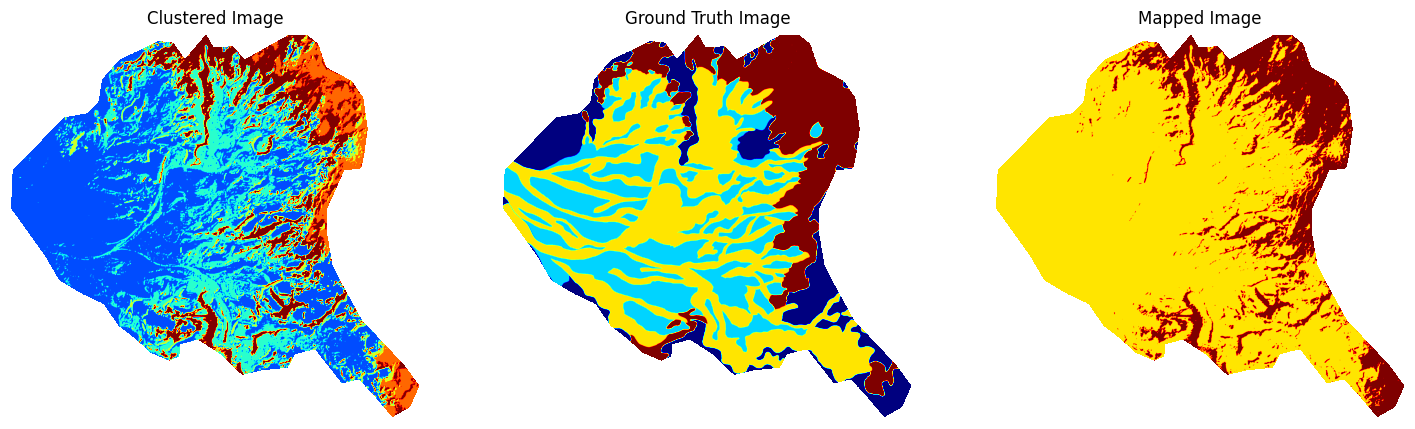

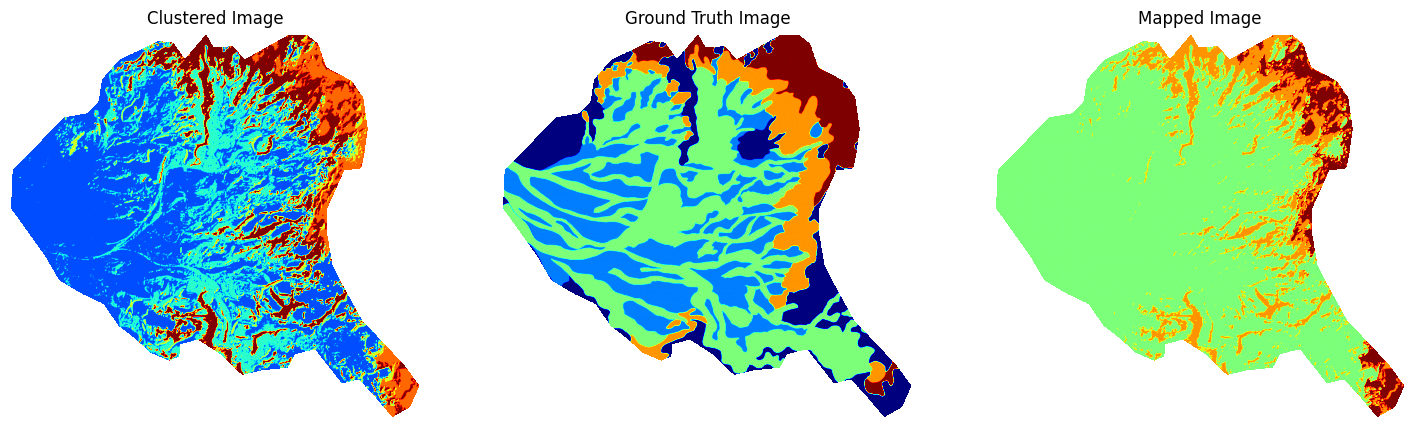

In [13]:
i = 22
results_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/results/CTX_masked_only/images/'
predicted_file = Image.open(results_path + df["filename"].loc[i])
predicted_color = np.array(predicted_file)
predicted = convert_from_color(predicted_color[:,:,:-1])

predicted_masked = predicted.astype(float).copy()
predicted_masked[masked_vals == 0] = np.nan

# LM2
LM2_mapped_img_mask, LM2_feature_map_mask, LM2_f1_mask = simple_overlap(predicted_masked, LM2_masked, plotting=True)

# LM3
LM3_mapped_img_mask, LM3_feature_map_mask, LM3_f1_mask = simple_overlap(predicted_masked, LM3_masked, plotting=True)

# LM4
LM4_mapped_img_mask, LM4_feature_map_mask, LM4_f1_mask = simple_overlap(predicted_masked, LM4_masked, plotting=True)

F1 Score: 0.5167
F1 Score: 0.1543
F1 Score: 0.1590


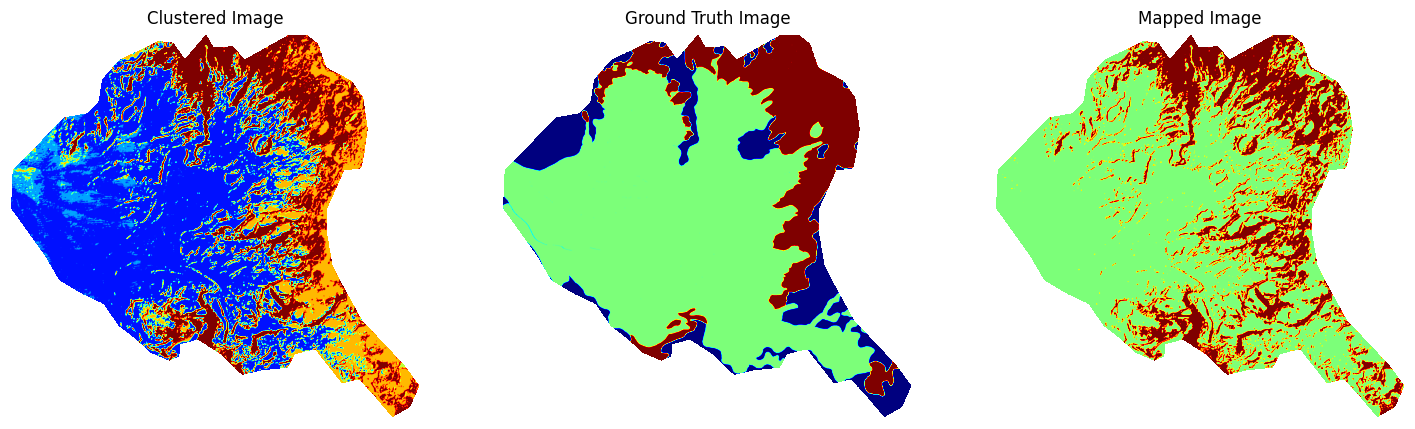

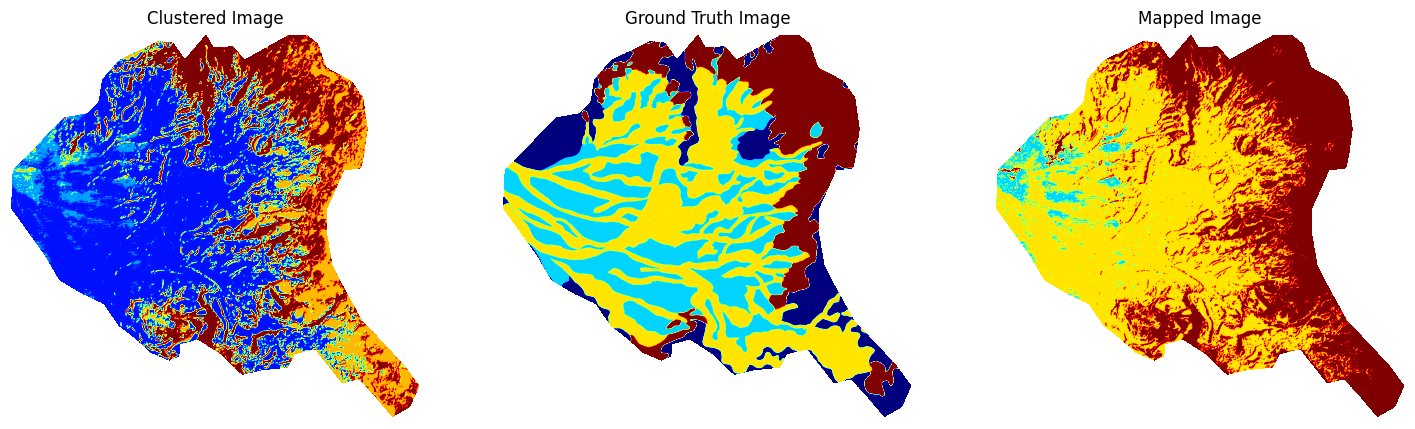

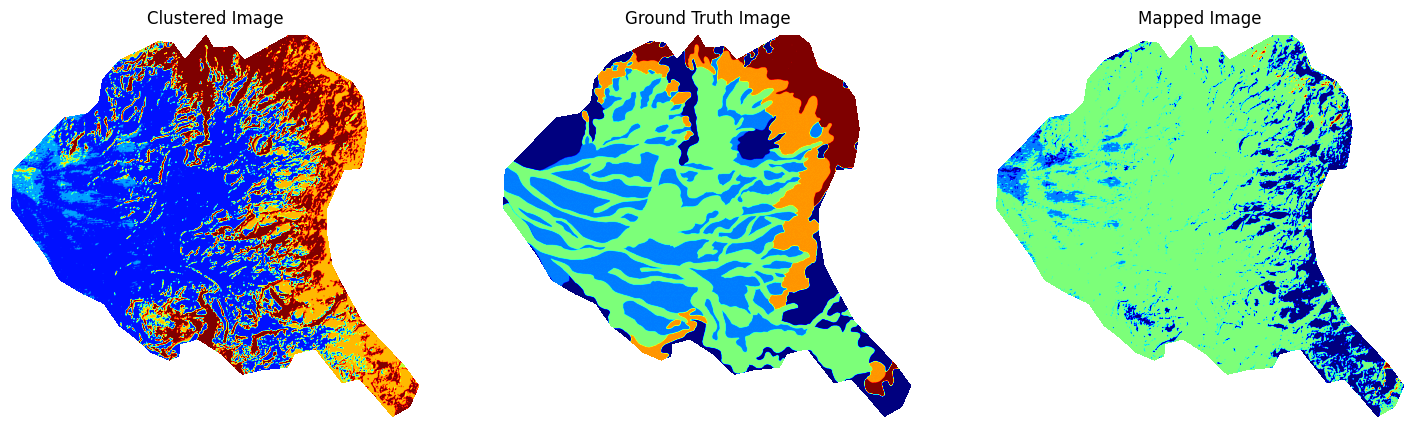

In [14]:
i = 7
results_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/results/CTX_masked_only/images/'
predicted_file = Image.open(results_path + df["filename"].loc[i])
predicted_color = np.array(predicted_file)
predicted = convert_from_color(predicted_color[:,:,:-1])

predicted_masked = predicted.astype(float).copy()
predicted_masked[masked_vals == 0] = np.nan

# LM2
LM2_mapped_img_mask, LM2_feature_map_mask, LM2_f1_mask = simple_overlap(predicted_masked, LM2_masked, plotting=True)

# LM3
LM3_mapped_img_mask, LM3_feature_map_mask, LM3_f1_mask = simple_overlap(predicted_masked, LM3_masked, plotting=True)

# LM4
LM4_mapped_img_mask, LM4_feature_map_mask, LM4_f1_mask = simple_overlap(predicted_masked, LM4_masked, plotting=True)

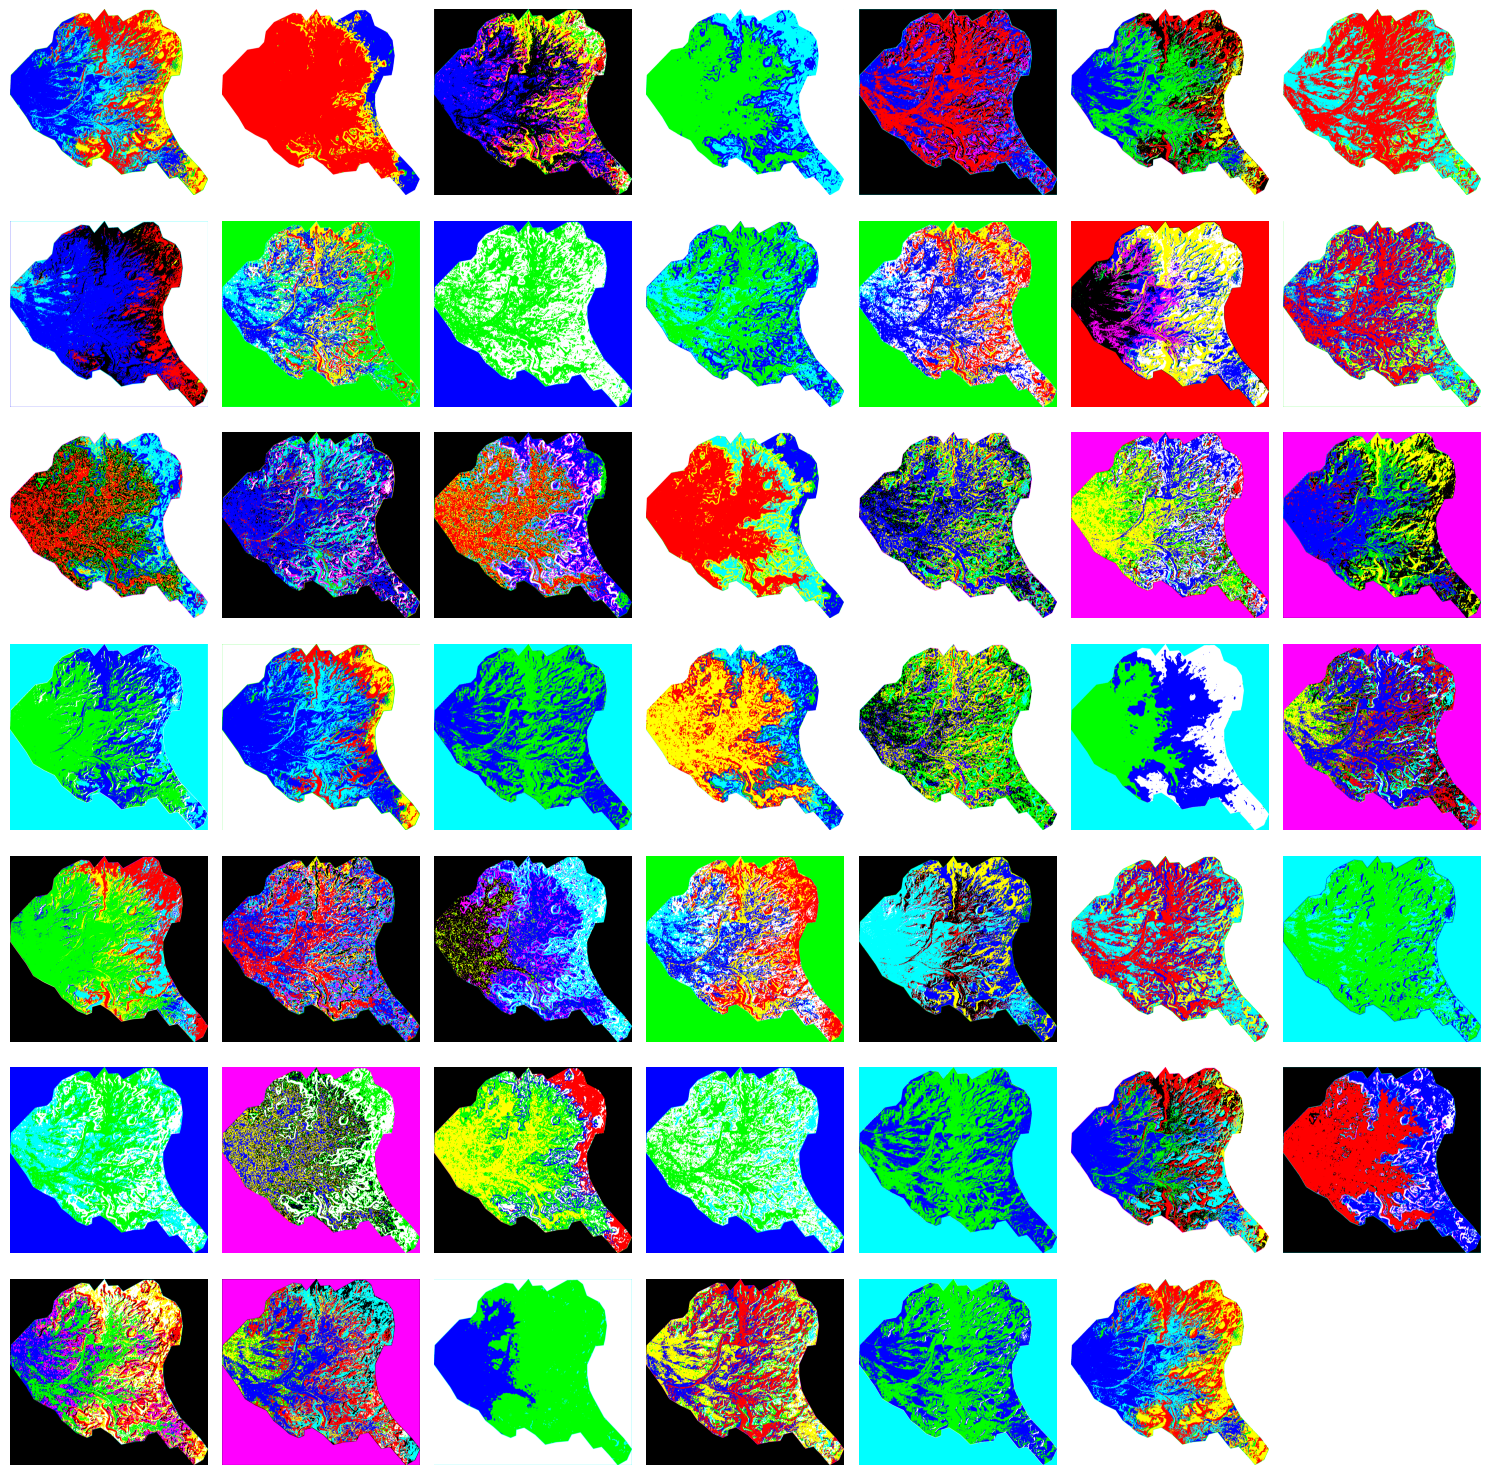

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the images
directory = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/results/CTX_masked_only/images/'

# Get list of image filenames in the directory
filenames = [f for f in os.listdir(directory) if f.endswith('.png')]

# Determine the grid size (e.g., 3x3 grid)
grid_size = int(len(filenames) ** 0.5) + 1

# Create a figure with subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Plot each image in the grid
for i, ax in enumerate(axes.flat):
    if i < len(filenames):
        # Open the image file
        img_path = os.path.join(directory, filenames[i])
        img = Image.open(img_path)
        
        # Display the image
        ax.imshow(img)
        # ax.set_title(filenames[i])
        ax.axis('off')
    else:
        # Hide any unused subplots
        ax.axis('off')

plt.tight_layout()
plt.show()